In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')# Set style for plots

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)



In [2]:

# Load the dataset
df = pd.read_csv("C:\\Users\\Win11\\Downloads\\archive (2)\\Global_EV_Charging_Behavior_2024.csv")

In [3]:
# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe(include='all'))

Dataset shape: (800, 16)

First few rows:
   Country      City Charging Station ID Charging Station Type  \
0  Germany    Berlin             CS-8195               DC Fast   
1      USA  New York             CS-5103               DC Fast   
2   France      Lyon             CS-4527               Level 1   
3    India    Mumbai             CS-5717               DC Fast   
4  Germany    Munich             CS-5093               Level 2   

                EV Model Manufacturer  Battery Capacity (kWh)  \
0  Hyundai Kona Electric      Hyundai                      64   
1            Nissan Leaf       Nissan                      40   
2                BYD Han          BYD                      76   
3            Nissan Leaf       Nissan                      40   
4            Nissan Leaf       Nissan                      40   

   Charging Start Time    Charging End Time  Charging Duration (mins)  \
0  2025-03-31 18:13:40  2025-03-31 19:30:40                        77   
1  2025-03-08 13:17:05  

In [4]:
# Convert datetime columns to proper datetime objects
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])
# Extract useful time features
df['Charging Hour'] = df['Charging Start Time'].dt.hour
df['Charging Day'] = df['Charging Start Time'].dt.day
df['Charging Month'] = df['Charging Start Time'].dt.month
df['Charging Day of Week'] = df['Charging Start Time'].dt.dayofweek  # Monday=0, Sunday=6


In [5]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Country                         0
City                            0
Charging Station ID             0
Charging Station Type           0
EV Model                        0
Manufacturer                    0
Battery Capacity (kWh)          0
Charging Start Time             0
Charging End Time               0
Charging Duration (mins)        0
Energy Delivered (kWh)          0
Charging Cost ($)               0
Payment Method                  0
Temperature (°C)                0
Charging Session Outcome        0
Station Utilization Rate (%)    0
Charging Hour                   0
Charging Day                    0
Charging Month                  0
Charging Day of Week            0
dtype: int64


In [6]:
df = df.dropna()  
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")



Number of duplicate rows: 0


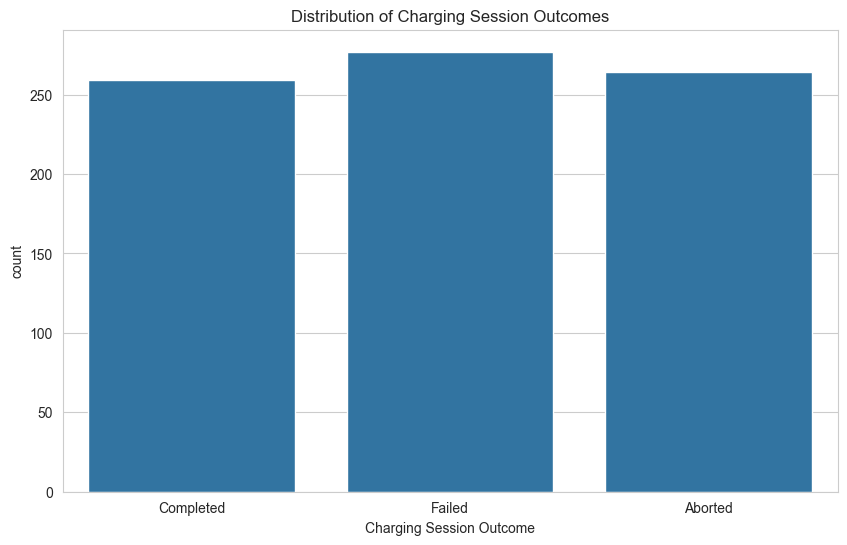

In [7]:
# 1. Target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Charging Session Outcome', data=df)
plt.title('Distribution of Charging Session Outcomes')
plt.show()

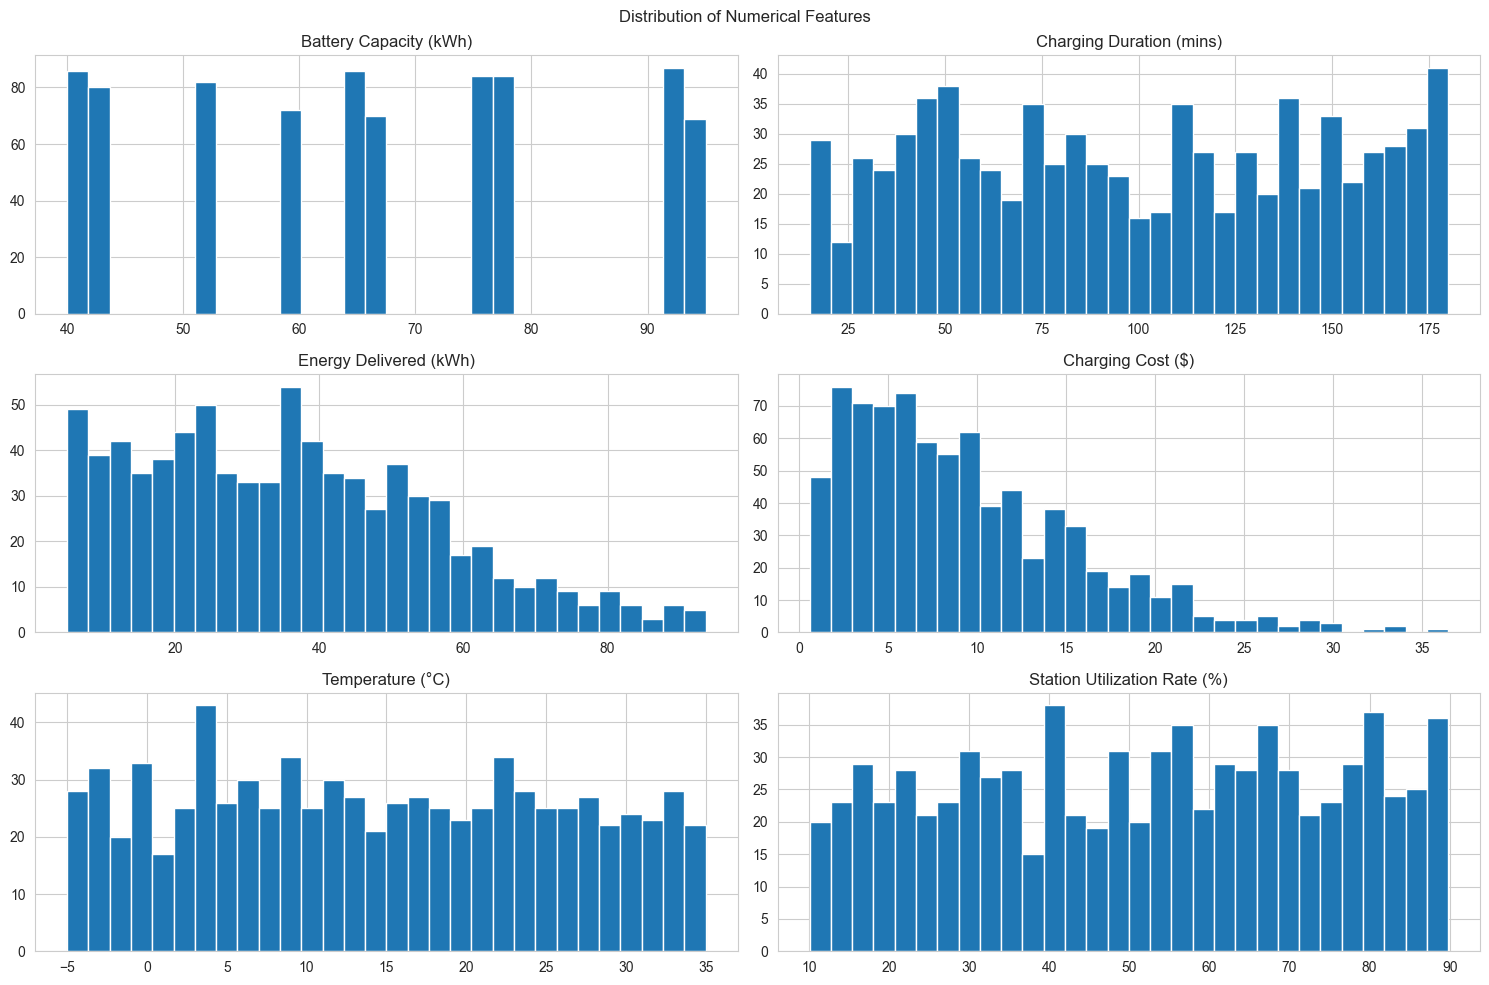

In [8]:
# 2. Numerical features distribution
num_cols = ['Battery Capacity (kWh)', 'Charging Duration (mins)', 'Energy Delivered (kWh)', 
            'Charging Cost ($)', 'Temperature (°C)', 'Station Utilization Rate (%)']
df[num_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

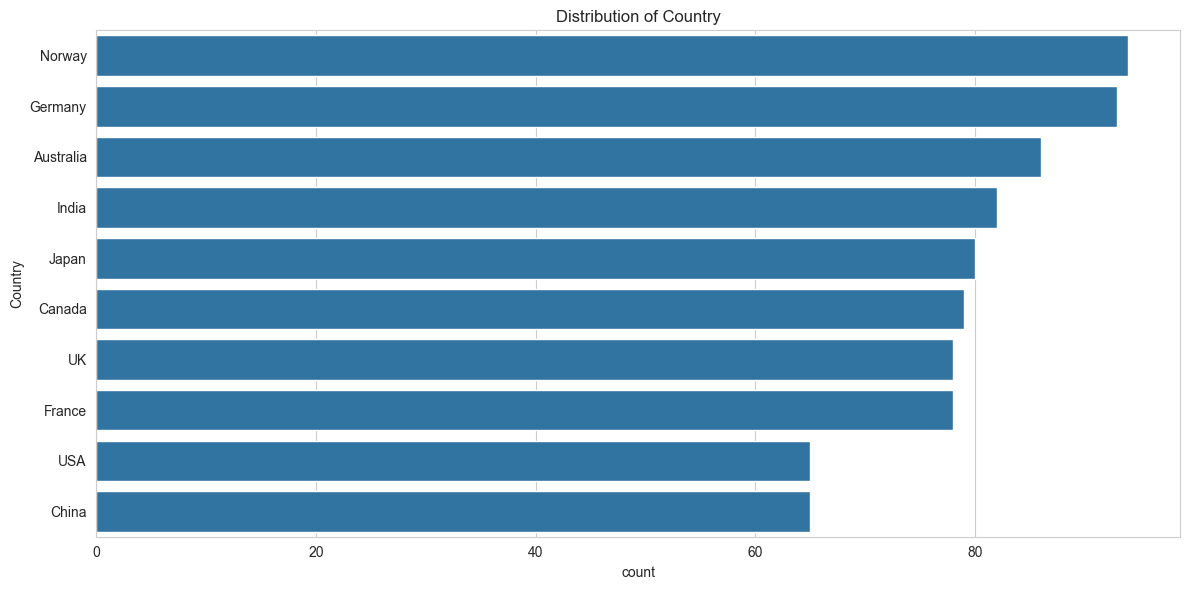

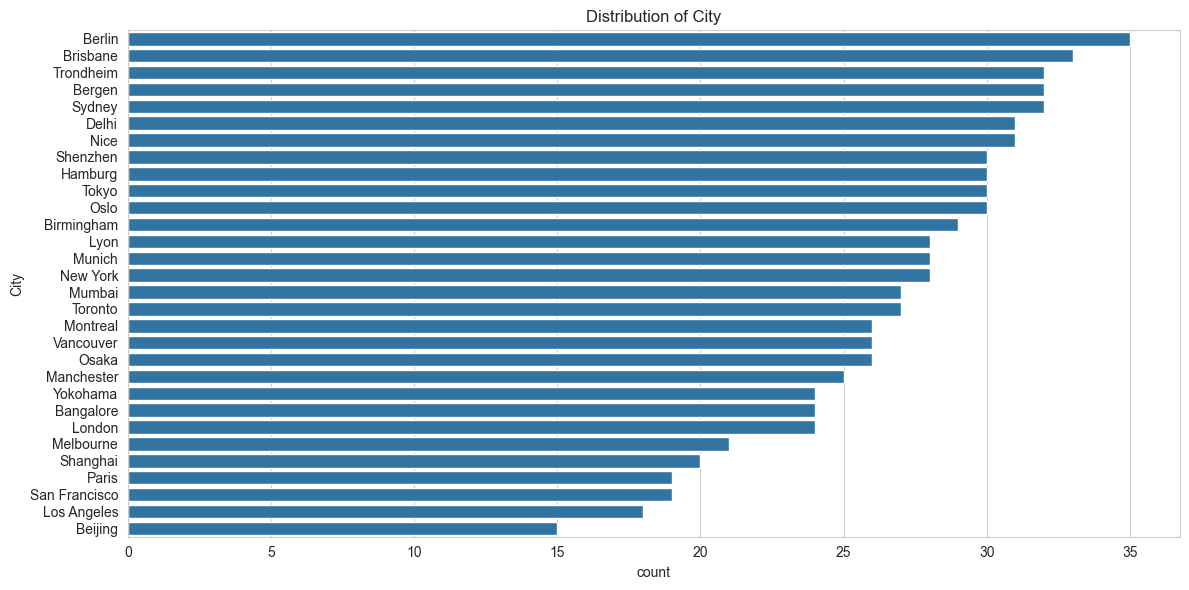

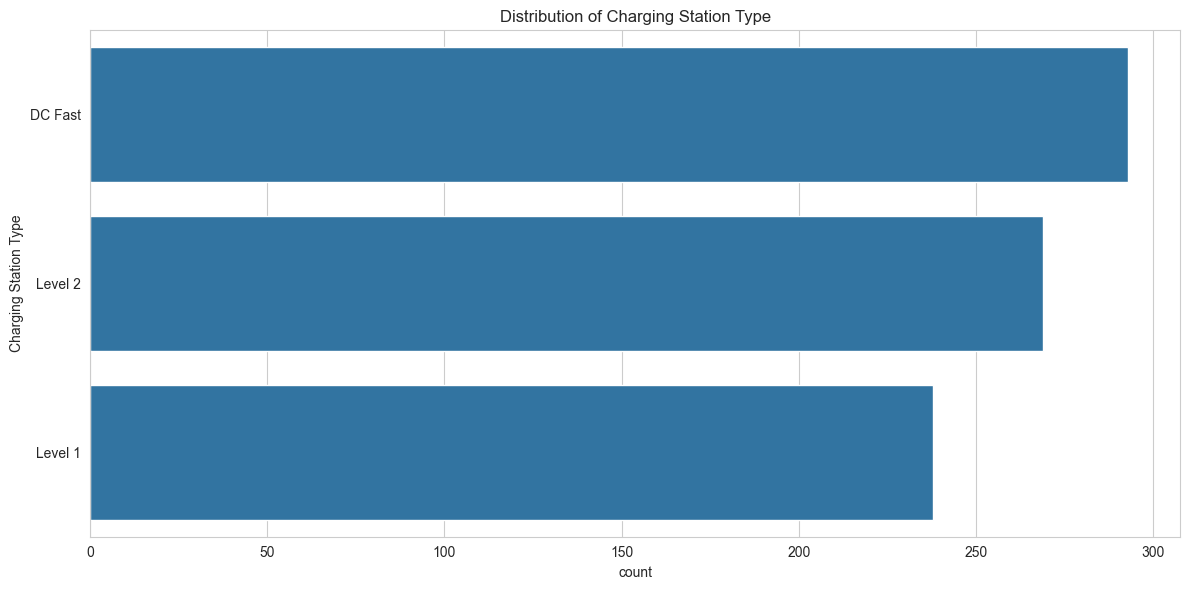

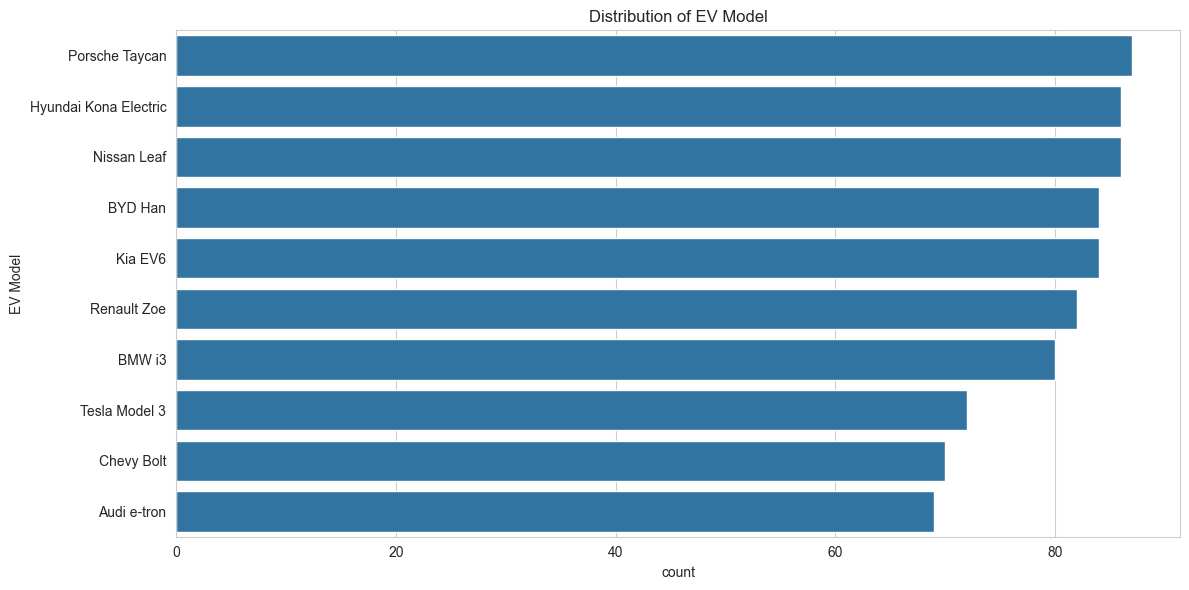

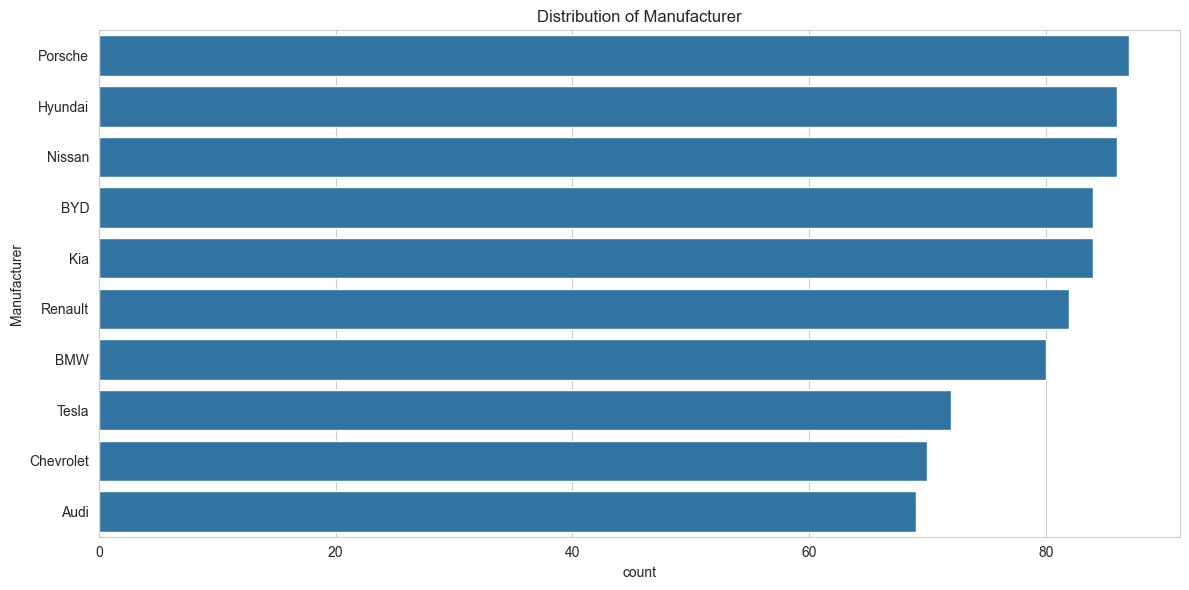

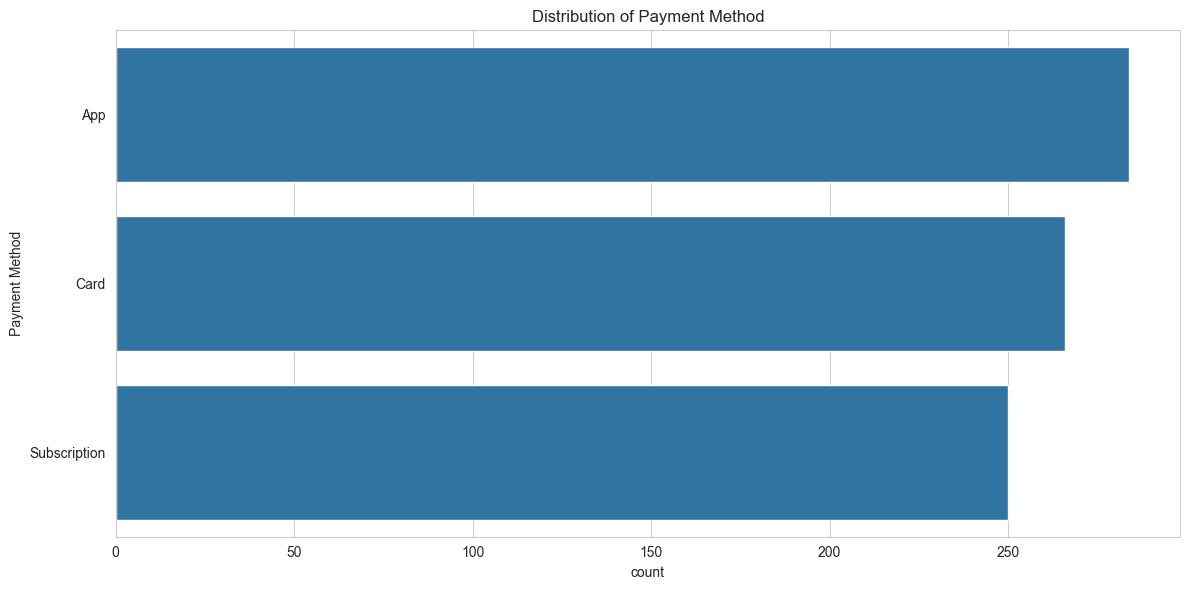

In [9]:
# 3. Categorical features distribution
cat_cols = ['Country', 'City', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Payment Method']
for col in cat_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

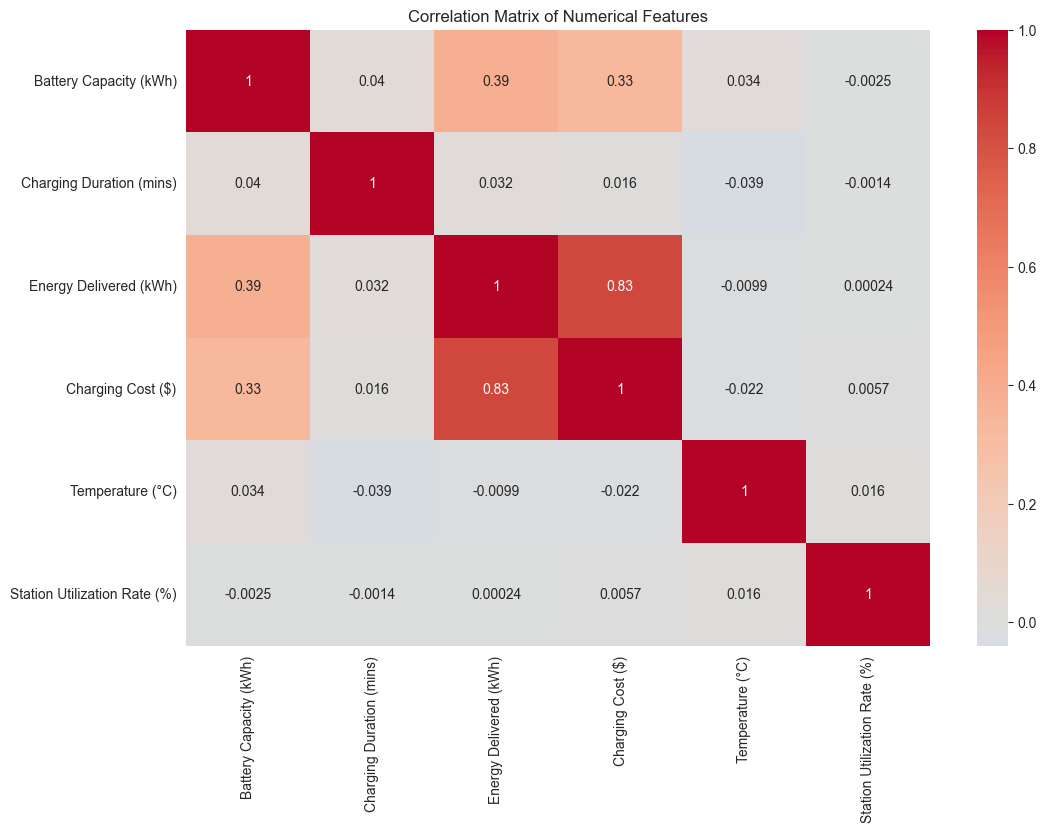

In [10]:
# 4. Correlation analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


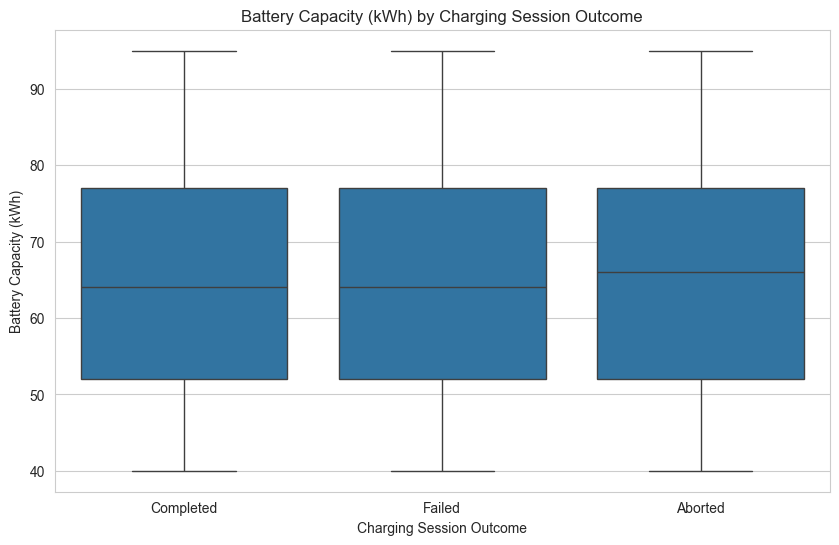

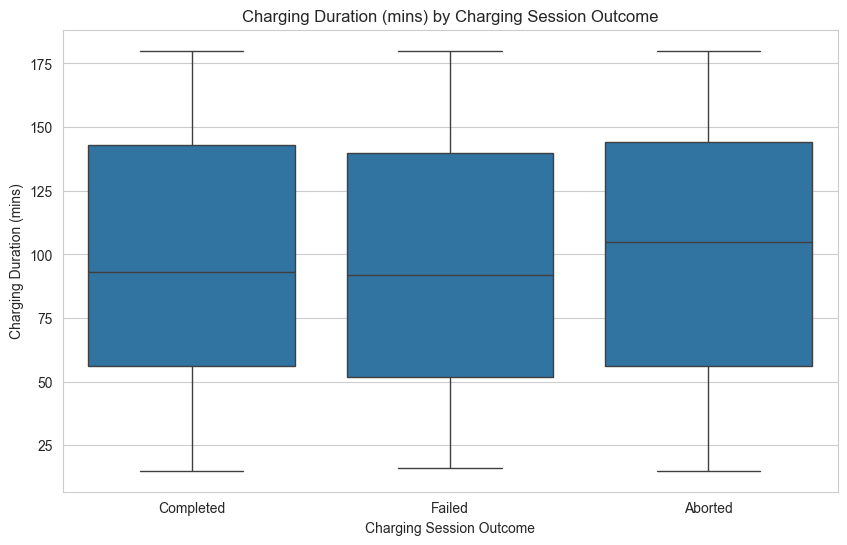

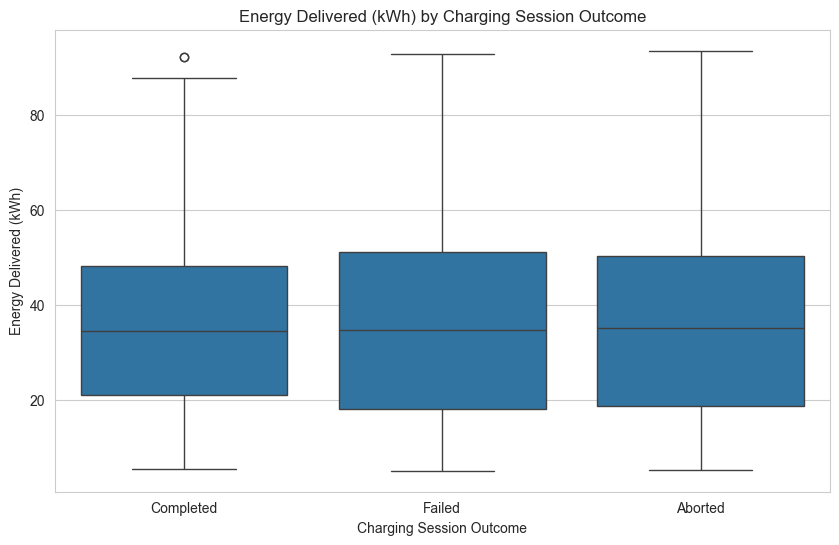

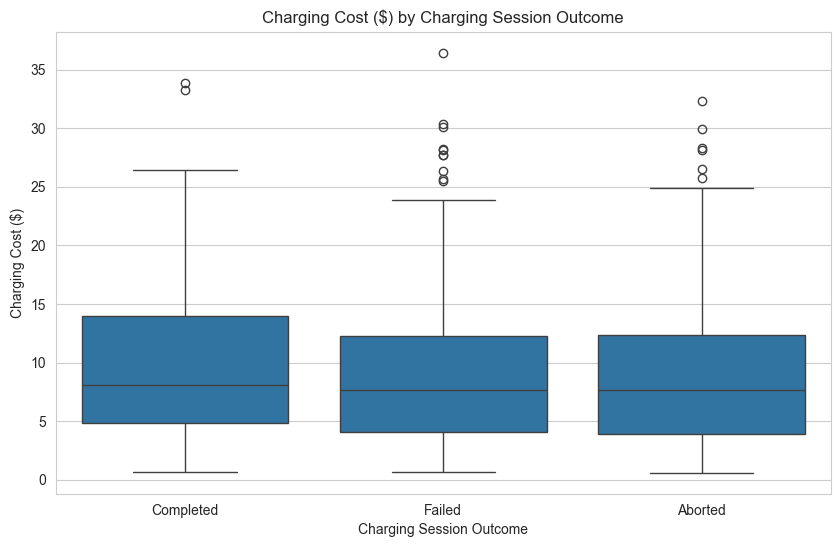

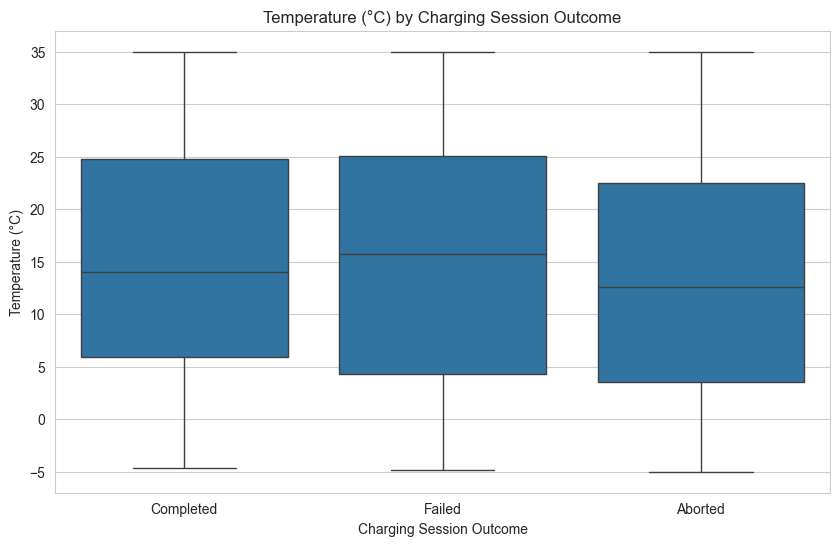

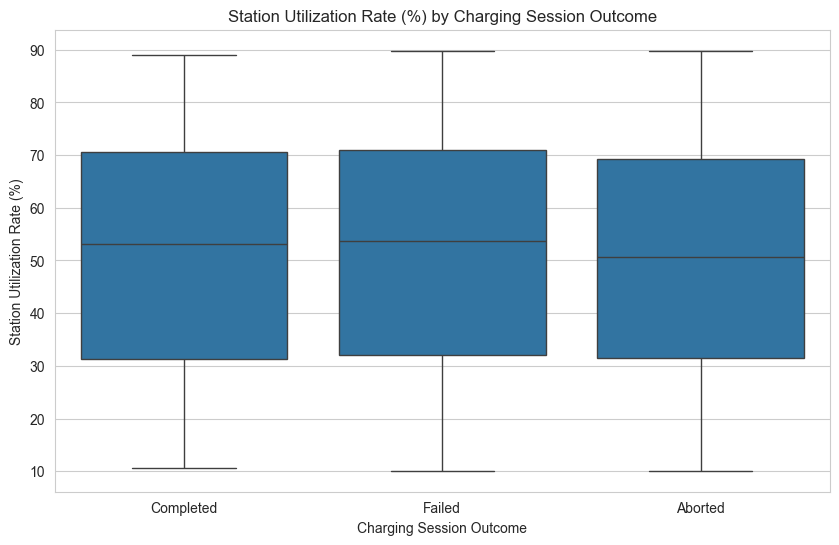

In [11]:
# 5. Relationship between features and target
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Charging Session Outcome', y=col, data=df)
    plt.title(f'{col} by Charging Session Outcome')
    plt.show()

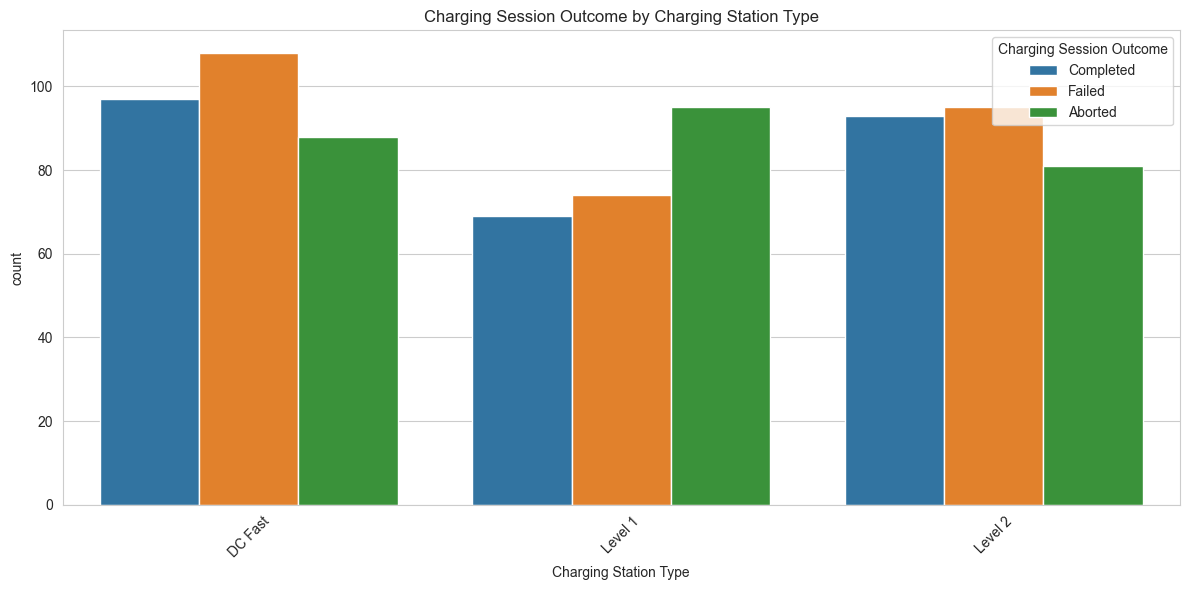

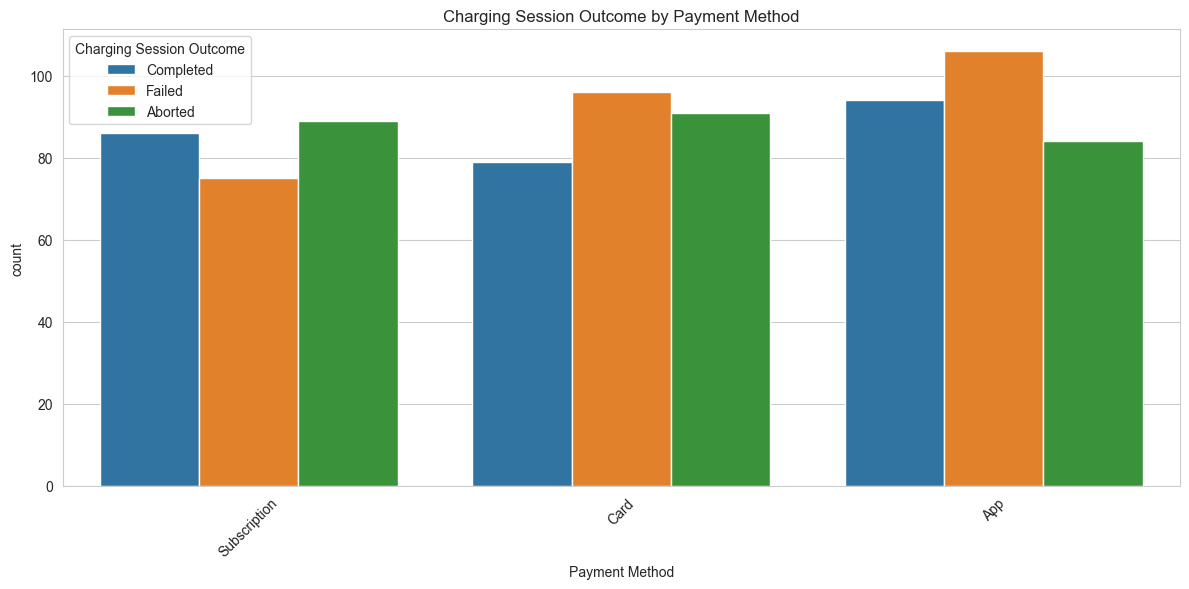

In [12]:

for col in ['Charging Station Type', 'Payment Method']:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=col, hue='Charging Session Outcome', data=df)
    plt.title(f'Charging Session Outcome by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


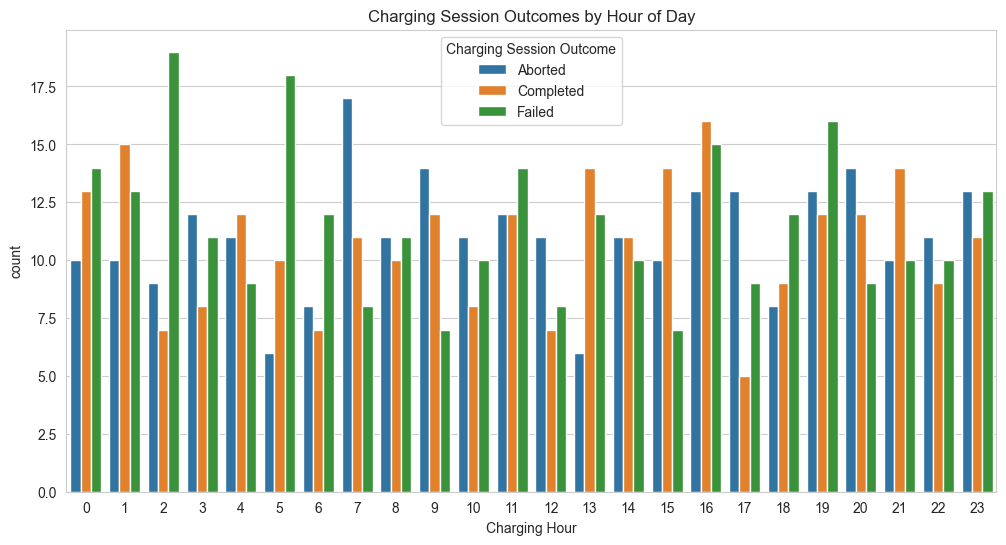

In [13]:
# 6. Time-based analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='Charging Hour', hue='Charging Session Outcome', data=df)
plt.title('Charging Session Outcomes by Hour of Day')
plt.show()

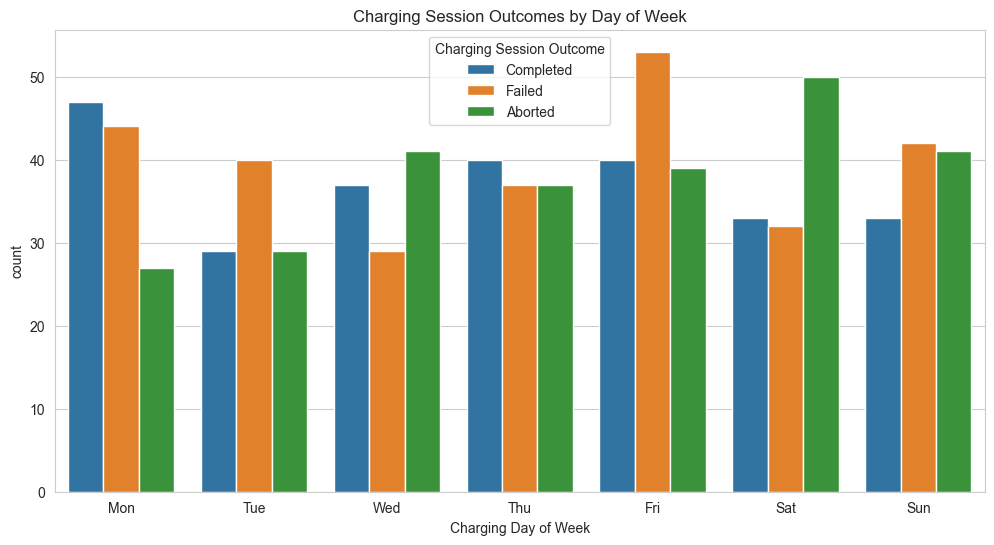

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Charging Day of Week', hue='Charging Session Outcome', data=df)
plt.title('Charging Session Outcomes by Day of Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [15]:
# Create new features that might be predictive
df['Charging Speed (kWh per min)'] = df['Energy Delivered (kWh)'] / df['Charging Duration (mins)']
df['Cost per kWh'] = df['Charging Cost ($)'] / df['Energy Delivered (kWh)']
df['Battery Percentage Charged'] = (df['Energy Delivered (kWh)'] / df['Battery Capacity (kWh)']) * 100

# Handle infinite values from division
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)  # or use more sophisticated imputation

# Bin temperature into categories
df['Temperature Category'] = pd.cut(df['Temperature (°C)'], 
                                   bins=[-float('inf'), 0, 10, 20, 30, float('inf')],
                                   labels=['Freezing', 'Cold', 'Cool', 'Mild', 'Hot'])
# Bin charging duration
df['Duration Category'] = pd.cut(df['Charging Duration (mins)'],
                                bins=[0, 30, 60, 120, 180, float('inf')],
                                labels=['<30min', '30-60min', '1-2h', '2-3h', '3h+'])



In [16]:
# Create a binary target for classification (1 for successful charging, 0 otherwise)
df['Charging Success'] = df['Charging Session Outcome'].apply(lambda x: 1 if x == 'Completed' else 0)

# Define features and target
X = df.drop(['Charging Session Outcome', 'Charging Success', 
             'Charging Start Time', 'Charging End Time',
             'Charging Station ID', 'EV Model'], axis=1)  # Dropping high-cardinality columns
y = df['Charging Success']

# Define preprocessing for numerical and categorical features
num_features = ['Battery Capacity (kWh)', 'Charging Duration (mins)', 'Energy Delivered (kWh)',
               'Charging Cost ($)', 'Temperature (°C)', 'Station Utilization Rate (%)',
               'Charging Hour', 'Charging Day', 'Charging Month', 'Charging Day of Week',
               'Charging Speed (kWh per min)', 'Cost per kWh', 'Battery Percentage Charged']
# Define preprocessing for numerical and categorical features
num_features = ['Battery Capacity (kWh)', 'Charging Duration (mins)', 'Energy Delivered (kWh)',
               'Charging Cost ($)', 'Temperature (°C)', 'Station Utilization Rate (%)',
               'Charging Hour', 'Charging Day', 'Charging Month', 'Charging Day of Week',
               'Charging Speed (kWh per min)', 'Cost per kWh', 'Battery Percentage Charged']

cat_features = ['Country', 'City', 'Charging Station Type', 'Manufacturer', 'Payment Method',
               'Temperature Category', 'Duration Category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])




In [17]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(df.columns)

# Define features and target
X = df.drop('Charging Success', axis=1)
y = df['Charging Success']


Index(['Country', 'City', 'Charging Station ID', 'Charging Station Type',
       'EV Model', 'Manufacturer', 'Battery Capacity (kWh)',
       'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)',
       'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method',
       'Temperature (°C)', 'Charging Session Outcome',
       'Station Utilization Rate (%)', 'Charging Hour', 'Charging Day',
       'Charging Month', 'Charging Day of Week',
       'Charging Speed (kWh per min)', 'Cost per kWh',
       'Battery Percentage Charged', 'Temperature Category',
       'Duration Category', 'Charging Success'],
      dtype='object')


In [18]:
# Define preprocessing for numerical and categorical features
num_features = ['Battery Capacity (kWh)', 'Charging Duration (mins)', 'Energy Delivered (kWh)',
               'Charging Cost ($)', 'Temperature (°C)', 'Station Utilization Rate (%)',
               'Charging Hour', 'Charging Day', 'Charging Month', 'Charging Day of Week',
               'Charging Speed (kWh per min)', 'Cost per kWh', 'Battery Percentage Charged']
# Define preprocessing for numerical and categorical features
num_features = ['Battery Capacity (kWh)', 'Charging Duration (mins)', 'Energy Delivered (kWh)',
               'Charging Cost ($)', 'Temperature (°C)', 'Station Utilization Rate (%)',
               'Charging Hour', 'Charging Day', 'Charging Month', 'Charging Day of Week',
               'Charging Speed (kWh per min)', 'Cost per kWh', 'Battery Percentage Charged']

cat_features = ['Country', 'City', 'Charging Station Type', 'Manufacturer', 'Payment Method',
               'Temperature Category', 'Duration Category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])


In [19]:

from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [20]:

from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [21]:
print(df.columns)

# Define features and target
X = df.drop('Charging Success', axis=1)
y = df['Charging Success']

Index(['Country', 'City', 'Charging Station ID', 'Charging Station Type',
       'EV Model', 'Manufacturer', 'Battery Capacity (kWh)',
       'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)',
       'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method',
       'Temperature (°C)', 'Charging Session Outcome',
       'Station Utilization Rate (%)', 'Charging Hour', 'Charging Day',
       'Charging Month', 'Charging Day of Week',
       'Charging Speed (kWh per min)', 'Cost per kWh',
       'Battery Percentage Charged', 'Temperature Category',
       'Duration Category', 'Charging Success'],
      dtype='object')


In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

In [23]:
# Define models to try
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
     # Create pipeline
    pipeline = Pipeline(steps=[('model', model)])
# Fit the model
pipeline.fit(X_train_res, y_train_res)
# Make predictions
y_pred = pipeline.predict(preprocessor.transform(X_test))

 #Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
results[name] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm
}


In [24]:
print(f"\n{name} Results:")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)



SVM Results:
Accuracy: 0.6062
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       108
           1       0.34      0.23      0.28        52

    accuracy                           0.61       160
   macro avg       0.51      0.51      0.50       160
weighted avg       0.57      0.61      0.58       160

Confusion Matrix:
[[85 23]
 [40 12]]


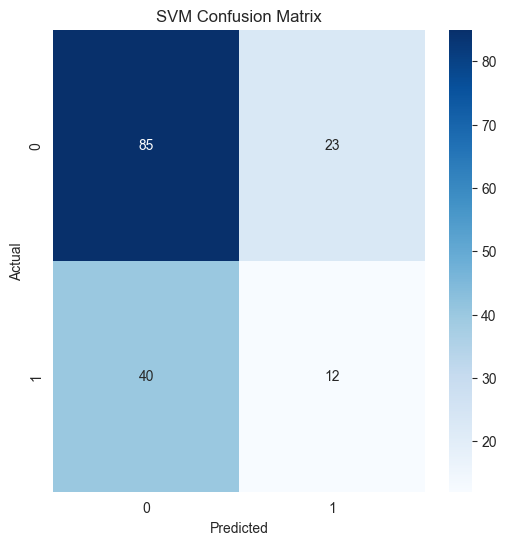

In [25]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'{name} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [26]:
# Define the parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])
#Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Battery '
                                                                          'Capacity '
                                                                          '(kWh)',
                                                                          'Charging '
                                                                          'Duration '
                                                                          '(mins)',
                                                                          'Energy '
                                                                          'Delivered '
                                                                          '(kWh)',
                                                                          'Charging '
                                                                          'Cost '
                                                                          '($)',
                                                                          'Temperature '
                                                                          '(°C)',
                                                                          'Station '
                                                                          'Utilization '
                                                                          'Rate '
                                                                          '(%)',
                                                                          'Charging '
                                                                          'Hour',
                                                                          'Charging '
                                                                          'Day',
                                                                          'Charging '
                                                                          'Month',
                                                                          'Charging '
                                                                          'Day '
                                                                          'of '
                                                                          'Wee...
                                                                          'Charging '
                                                                          'Station '
                                                                          'Type',
                                                                          'Manufacturer',
                                                                          'Payment '
                                                                          'Method',
                                                                          'Temperature '
                                                                          'Category',
                                                                          'Duration '
                                                                          'Category'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [27]:
# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline


In [28]:

# Now you can use make_pipeline()
pipeline = make_pipeline(...) 
param_grid = {...}

In [29]:

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(StandardScaler(), LogisticRegression())
# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)



In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5)


In [ ]:
c

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

model = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, refit=True)
grid_search.fit(X_train, y_train)




ValueError: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_gb.py", line 658, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<4 lines>...
        multi_output=True,
        ^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Canada'

--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_gb.py", line 658, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<4 lines>...
        multi_output=True,
        ^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'France'


In [ ]:
print(grid_search.cv_results_)  # Check if results exist


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [33]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [34]:
print("\nBest Model Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best Model Test Results:
Accuracy: 0.6062
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       108
           1       0.34      0.23      0.28        52

    accuracy                           0.61       160
   macro avg       0.51      0.51      0.50       160
weighted avg       0.57      0.61      0.58       160

Confusion Matrix:
[[85 23]
 [40 12]]


In [35]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])



In [36]:

# Fit the grid search
try:
    grid_search.fit(X_train, y_train)
    print("Best Estimator:", grid_search.best_estimator_)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
except Exception as e:
    print(f"Error during grid search: {e}")

Error during grid search: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_gb.py", line 658, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...

In [37]:
import joblib
from sklearn.ensemble import GradientBoostingClassifier

# Train the model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Save the model
joblib.dump(gb_model, 'gradient_boosting_model.pkl')


ValueError: could not convert string to float: 'France'

In [38]:
import joblib

# Save the best model
model_filename = 'ev_charging1_success_predictor.pkl'
joblib.dump(best_model, model_filename)

# Save the preprocessor
preprocessor_filename = 'ev_charging1_preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_filename)

print(f"Model saved as {model_filename}")
print(f"Preprocessor saved as {preprocessor_filename}")

# To load and use later:loaded_model
# loaded_model = joblib.load(model_filename)
# loaded_preprocessor = joblib.load(preprocessor_filename)
# new_data_processed = loaded_preprocessor.transform(new_data)
# predictions = loaded_model.predict(new_data_processed)

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

NameError: name 'best_model' is not defined

In [39]:
# Dictionary to store all models and their results
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__penalty': ['l2']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.1, 0.05],
            'model__max_depth': [3, 5]
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    }
}

# Train and evaluate each model
results = {}
for name, config in models.items():
    print(f"\n{'='*50}")
    print(f"Training and evaluating {name}")
    print(f"{'='*50}")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])
    
    # Perform grid search if parameters are specified
    if config['params']:
        print(f"Performing grid search for {name}...")
        grid_search = GridSearchCV(
            pipeline,
            param_grid=config['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        # Get best model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {name}: {best_params}")
        
        # Store best model
        models[name]['best_model'] = best_model
    else:
        # Fit the model without grid search
        pipeline.fit(X_train_res, y_train_res)
        models[name]['best_model'] = pipeline
    
    # Make predictions
y_pred = models[name]['best_model'].predict(X_test)
    
    # Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
    
    # Store results
results[name] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm
    }


Training and evaluating Logistic Regression
Performing grid search for Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Logistic Regression: {'model__C': 0.1, 'model__penalty': 'l2'}

Training and evaluating Random Forest
Performing grid search for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Random Forest: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}

Training and evaluating Gradient Boosting
Performing grid search for Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Gradient Boosting: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

Training and evaluating SVM
Performing grid search for SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for SVM: {'model__C': 0.1, 'model__kernel': 'linear'}


In [40]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd

df = pd.read_csv("C:\\Users\\Win11\\Downloads\\archive (2)\\Global_EV_Charging_Behavior_2024.csv")  

print(df.columns.tolist())

df.columns = df.columns.str.strip()

# Step 1: Check actual column names
print("Actual columns:")
for col in df.columns:
    print(f"'{col}'")  # Shows spaces or invisible characters

# Step 2: Strip whitespaces and rename columns safely
df.columns = df.columns.str.strip()

# Step 3: Check again after strip
print("\nAfter stripping:")
print(df.columns.tolist())

# Step 4: Check if 'Charging Success' exists now
if "Charging Success" in df.columns:
    print("\n'Charging Success' column found!")
    # Proceed to split data
    X = df.drop("Charging Success", axis=1)
    y = df["Charging Success"]
else:
    print("\nERROR: 'Charging Success' column NOT found.")
# Create a dummy target column for demo purposes
# Let's assume: charging duration > 30 mins is considered "successful"
df["Charging Success"] = df["Charging Duration (mins)"].apply(lambda x: 1 if x > 30 else 0)

# Now split into features and target
X = df.drop("Charging Success", axis=1)
y = df["Charging Success"]

# Encode categorical columns if needed
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# Scale data (optional but good for models like SVM, Logistic Regression, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}
# Train & evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Use scaled data for some models
    if name in ["Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors", "Naive Bayes"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train & evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Use scaled data for some models
    if name in ["Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors", "Naive Bayes"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

joblib.dump(gb_model, 'gradient_boosting_model.pkl')

import joblib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# Assuming you've already split your data and trained the model

# Train your model (Example with GradientBoostingClassifier)
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Define your preprocessor (Example with StandardScaler)
preprocessor = StandardScaler()
X_train_scaled = preprocessor.fit_transform(X_train)  # Fit and transform your training data

# Save the trained model and preprocessor
model_filename = 'ev_charging3_success_predictor.pkl'
joblib.dump(gb_model, model_filename)

preprocessor_filename = 'ev_charging3_preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_filename)

print(f"Model saved as {model_filename}")
print(f"Preprocessor saved as {preprocessor_filename}")


['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Battery Capacity (kWh)', 'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method', 'Temperature (°C)', 'Charging Session Outcome', 'Station Utilization Rate (%)']
Actual columns:
'Country'
'City'
'Charging Station ID'
'Charging Station Type'
'EV Model'
'Manufacturer'
'Battery Capacity (kWh)'
'Charging Start Time'
'Charging End Time'
'Charging Duration (mins)'
'Energy Delivered (kWh)'
'Charging Cost ($)'
'Payment Method'
'Temperature (°C)'
'Charging Session Outcome'
'Station Utilization Rate (%)'

After stripping:
['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Battery Capacity (kWh)', 'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method', 'Temperature (°C)', 'Charging Session Outcome'

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


In [42]:
import pandas as pd


In [43]:
df = pd.read_csv("C:\\Users\\Win11\\Downloads\\archive (2)\\Global_EV_Charging_Behavior_2024.csv")  


In [44]:

print(df.columns.tolist())

['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Battery Capacity (kWh)', 'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method', 'Temperature (°C)', 'Charging Session Outcome', 'Station Utilization Rate (%)']


In [45]:
df.columns = df.columns.str.strip()


In [46]:
# Step 1: Check actual column names
print("Actual columns:")
for col in df.columns:
    print(f"'{col}'")  # Shows spaces or invisible characters

# Step 2: Strip whitespaces and rename columns safely
df.columns = df.columns.str.strip()

# Step 3: Check again after strip
print("\nAfter stripping:")
print(df.columns.tolist())

# Step 4: Check if 'Charging Success' exists now
if "Charging Success" in df.columns:
    print("\n'Charging Success' column found!")
    # Proceed to split data
    X = df.drop("Charging Success", axis=1)
    y = df["Charging Success"]
else:
    print("\nERROR: 'Charging Success' column NOT found.")
# Create a dummy target column for demo purposes
# Let's assume: charging duration > 30 mins is considered "successful"
df["Charging Success"] = df["Charging Duration (mins)"].apply(lambda x: 1 if x > 30 else 0)

# Now split into features and target
X = df.drop("Charging Success", axis=1)
y = df["Charging Success"]

# Encode categorical columns if needed
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale data (optional but good for models like SVM, Logistic Regression, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Actual columns:
'Country'
'City'
'Charging Station ID'
'Charging Station Type'
'EV Model'
'Manufacturer'
'Battery Capacity (kWh)'
'Charging Start Time'
'Charging End Time'
'Charging Duration (mins)'
'Energy Delivered (kWh)'
'Charging Cost ($)'
'Payment Method'
'Temperature (°C)'
'Charging Session Outcome'
'Station Utilization Rate (%)'

After stripping:
['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Battery Capacity (kWh)', 'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method', 'Temperature (°C)', 'Charging Session Outcome', 'Station Utilization Rate (%)']

ERROR: 'Charging Success' column NOT found.


In [47]:

# Define models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}
# Train & evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Use scaled data for some models
    if name in ["Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors", "Naive Bayes"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



=== Logistic Regression ===
Accuracy: 0.9187
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.92      1.00      0.96       147

    accuracy                           0.92       160
   macro avg       0.46      0.50      0.48       160
weighted avg       0.84      0.92      0.88       160

Confusion Matrix:
[[  0  13]
 [  0 147]]

=== Random Forest ===
Accuracy: 0.9313
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.27        13
           1       0.93      1.00      0.96       147

    accuracy                           0.93       160
   macro avg       0.97      0.58      0.62       160
weighted avg       0.94      0.93      0.91       160

Confusion Matrix:
[[  2  11]
 [  0 147]]

=== Gradient Boosting ===
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

          

In [48]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train & evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Use scaled data for some models
    if name in ["Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors", "Naive Bayes"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

joblib.dump(gb_model, 'gradient_boosting_model.pkl')




=== Logistic Regression ===
Accuracy: 0.9187
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.92      1.00      0.96       147

    accuracy                           0.92       160
   macro avg       0.46      0.50      0.48       160
weighted avg       0.84      0.92      0.88       160

Confusion Matrix:
[[  0  13]
 [  0 147]]

=== Random Forest ===
Accuracy: 0.9812
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.98      1.00      0.99       147

    accuracy                           0.98       160
   macro avg       0.99      0.88      0.93       160
weighted avg       0.98      0.98      0.98       160

Confusion Matrix:
[[ 10   3]
 [  0 147]]

=== Gradient Boosting ===
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

          

['gradient_boosting_model.pkl']

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd

# Load your dataset
df = pd.read_csv("C:\\Users\\Win11\\Downloads\\archive (2)\\Global_EV_Charging_Behavior_2024.csv")  # change to your file name

# Split X and y
X = df.drop("Charging Success", axis=1)
y = df["Charging Success"]

# Encode categorical columns if needed
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale data (optional but good for models like SVM, Logistic Regression, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Train & evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Use scaled data for some models
    if name in ["Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors", "Naive Bayes"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


KeyError: "['Charging Success'] not found in axis"

In [50]:
print(df.columns.tolist())


['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Battery Capacity (kWh)', 'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method', 'Temperature (°C)', 'Charging Session Outcome', 'Station Utilization Rate (%)']


In [51]:
df.columns = df.columns.str.strip()


In [52]:
# Create a dummy target column for demo purposes
# Let's assume: charging duration > 30 mins is considered "successful"
df["Charging Success"] = df["Charging Duration (mins)"].apply(lambda x: 1 if x > 30 else 0)

# Now split into features and target
X = df.drop("Charging Success", axis=1)
y = df["Charging Success"]


In [53]:
print(df.columns)
df.drop(columns=['Charging Success'], errors='ignore', inplace=True)
df.columns = df.columns.str.strip()


Index(['Country', 'City', 'Charging Station ID', 'Charging Station Type',
       'EV Model', 'Manufacturer', 'Battery Capacity (kWh)',
       'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)',
       'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method',
       'Temperature (°C)', 'Charging Session Outcome',
       'Station Utilization Rate (%)', 'Charging Success'],
      dtype='object')


In [54]:
if 'Charging Success' in df.columns:
    df.drop(columns=['Charging Success'], inplace=True)
else:
    print("Column 'Charging Success' not found.")


Column 'Charging Success' not found.


In [55]:
print(df.columns.tolist())


['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Battery Capacity (kWh)', 'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method', 'Temperature (°C)', 'Charging Session Outcome', 'Station Utilization Rate (%)']


In [56]:
df = df.dropna()  # or df.fillna(method="ffill") if appropriate


In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score

for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Use scaled or unscaled data appropriately
    if name in ["Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors", "Naive Bayes"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")



=== Logistic Regression ===
Accuracy:  0.9187
Precision: 0.8441
Recall:    0.9187
F1 Score:  0.8798

=== Random Forest ===
Accuracy:  0.9250
Precision: 0.9307
Recall:    0.9250
F1 Score:  0.8943

=== Gradient Boosting ===
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000

=== Decision Tree ===
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000

=== Support Vector Machine ===
Accuracy:  0.9187
Precision: 0.8441
Recall:    0.9187
F1 Score:  0.8798

=== Naive Bayes ===
Accuracy:  0.2375
Precision: 0.8921
Recall:    0.2375
F1 Score:  0.2879

=== K-Nearest Neighbors ===
Accuracy:  0.9187
Precision: 0.8441
Recall:    0.9187
F1 Score:  0.8798


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd

# Load your dataset
df = pd.read_csv("C:\\Users\\Win11\\Downloads\\archive (2)\\Global_EV_Charging_Behavior_2024.csv")  # change to your file name

# Split X and y
df.columns = df.columns.str.strip()
X = df.drop('Charging_Success', axis=1)
y = df['Charging_Success']



# Encode categorical columns if needed
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale data (optional but good for models like SVM, Logistic Regression, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Train & evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Use scaled data for some models
    if name in ["Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors", "Naive Bayes"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


KeyError: "['Charging_Success'] not found in axis"

In [59]:
if 'Charging Success' in df.columns:
    df.drop(columns=['Charging Success'], inplace=True)
else:
    print("Column 'Charging Success' not found.")


Column 'Charging Success' not found.


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# 1. Features and target
X = df.drop("Charging Success", axis=1)
y = df["Charging Success"]

# 2. Encode if needed
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# 5. Train and evaluate each model
print("Model Accuracy Comparison:\n")
best_model = None
best_accuracy = 0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"{name}: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = name

print(f"\n✅ Best Performing Model: {best_model} with accuracy: {best_accuracy:.4f}")


KeyError: "['Charging Success'] not found in axis"

In [61]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.92      1.00      0.96       147

    accuracy                           0.92       160
   macro avg       0.46      0.50      0.48       160
weighted avg       0.84      0.92      0.88       160

Confusion Matrix:
[[  0  13]
 [  0 147]]


In [62]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(DecisionTreeClassifier(), X, y, cv=5)
print(f"Decision Tree CV Accuracy: {scores.mean():.4f}")


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\tree\_classes.py", line 1024, in fit
    super()._fit(
    ~~~~~~~~~~~~^
        X,
        ^^
    ...<2 lines>...
        check_input=check_input,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\tree\_classes.py", line 252, in _fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self, X, y, validate_separately=(check_X_params, check_y_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 2956, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Norway'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\tree\_classes.py", line 1024, in fit
    super()._fit(
    ~~~~~~~~~~~~^
        X,
        ^^
    ...<2 lines>...
        check_input=check_input,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\tree\_classes.py", line 252, in _fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self, X, y, validate_separately=(check_X_params, check_y_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 2956, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Win11\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Germany'


In [63]:
# Simulate EV charging behavior dataset
def generate_ev_data(num_records=1000):
    data = []
    start_time = datetime(2025, 1, 1, 0, 0)

    for i in range(num_records):
        start = start_time + timedelta(minutes=random.randint(0, 100000))
        duration = random.randint(20, 120)  # charging time in minutes
        energy_kwh = round(duration * random.uniform(0.1, 0.25), 2)
        location = random.choice(['USA', 'Germany', 'India', 'China', 'UK', 'France'])
        charger_type = random.choice(['Level 1', 'Level 2', 'DC Fast'])

        data.append({
            'Start Time': start,
            'Duration (min)': duration,
            'Energy (kWh)': energy_kwh,
            'Location': location,
            'Charger Type': charger_type
        })

    return pd.DataFrame(data)

# Generate data
df = generate_ev_data()

# Convert to hourly and daily patterns
df['Hour'] = df['Start Time'].dt.hour
df['Day'] = df['Start Time'].dt.day_name()

# Visualization 1: Charging sessions by hour
plt.figure(figsize=(10, 5))
df['Hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('EV Charging Sessions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.grid(axis='y')
plt.show()

# Visualization 2: Energy consumption by charger type
plt.figure(figsize=(8, 5))
df.groupby('Charger Type')['Energy (kWh)'].mean().plot(kind='bar', color='green')
plt.title('Average Energy Consumption by Charger Type')
plt.ylabel('Avg Energy (kWh)')
plt.xlabel('Charger Type')
plt.grid(axis='y')
plt.show()

# Visualization 3: Sessions by Country
plt.figure(figsize=(8, 5))
df['Location'].value_counts().plot(kind='barh', color='orange')
plt.title('Charging Sessions by Country')
plt.xlabel('Number of Sessions')
plt.ylabel('Country')
plt.grid(axis='x')
plt.show()


NameError: name 'timedelta' is not defined

In [64]:
# Simulate EV charging behavior dataset
def generate_ev_data(num_records=1000):
    data = []
    start_time = datetime(2025, 1, 1, 0, 0)

    for i in range(num_records):
        start = start_time + timedelta(minutes=random.randint(0, 100000))
        duration = random.randint(20, 120)  # charging time in minutes
        energy_kwh = round(duration * random.uniform(0.1, 0.25), 2)
        location = random.choice(['USA', 'Germany', 'India', 'China', 'UK', 'France'])
        charger_type = random.choice(['Level 1', 'Level 2', 'DC Fast'])

        data.append({
            'Start Time': start,
            'Duration (min)': duration,
            'Energy (kWh)': energy_kwh,
            'Location': location,
            'Charger Type': charger_type
        })

    return pd.DataFrame(data)

# Generate data
df = generate_ev_data()

# Convert to hourly and daily patterns
df['Hour'] = df['Start Time'].dt.hour
df['Day'] = df['Start Time'].dt.day_name()

# Visualization 1: Charging sessions by hour
plt.figure(figsize=(10, 5))
df['Hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('EV Charging Sessions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.grid(axis='y')
plt.show()

# Visualization 2: Energy consumption by charger type
plt.figure(figsize=(8, 5))
df.groupby('Charger Type')['Energy (kWh)'].mean().plot(kind='bar', color='green')
plt.title('Average Energy Consumption by Charger Type')
plt.ylabel('Avg Energy (kWh)')
plt.xlabel('Charger Type')
plt.grid(axis='y')
plt.show()

# Visualization 3: Sessions by Country
plt.figure(figsize=(8, 5))
df['Location'].value_counts().plot(kind='barh', color='orange')
plt.title('Charging Sessions by Country')
plt.xlabel('Number of Sessions')
plt.ylabel('Country')
plt.grid(axis='x')
plt.show()


NameError: name 'timedelta' is not defined

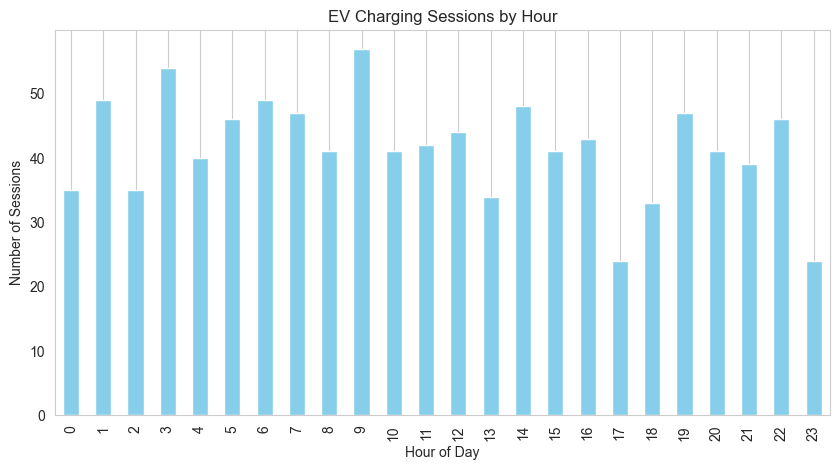

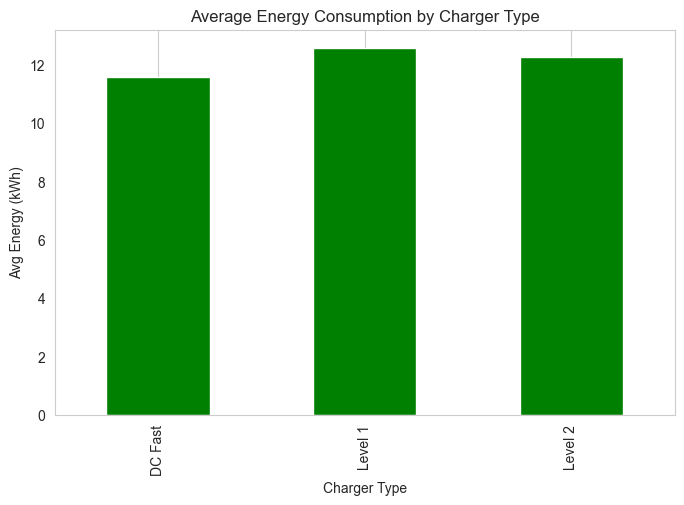

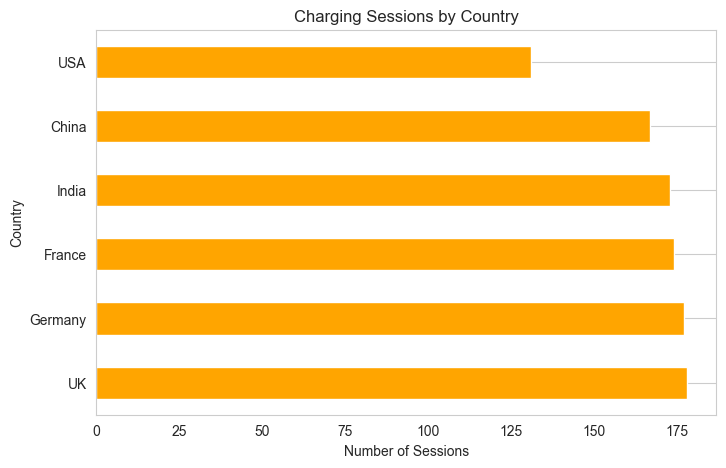

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

# Simulate EV charging behavior dataset
def generate_ev_data(num_records=1000):
    data = []
    start_time = datetime(2025, 1, 1, 0, 0)

    for i in range(num_records):
        start = start_time + timedelta(minutes=random.randint(0, 100000))
        duration = random.randint(20, 120)  # charging time in minutes
        energy_kwh = round(duration * random.uniform(0.1, 0.25), 2)
        location = random.choice(['USA', 'Germany', 'India', 'China', 'UK', 'France'])
        charger_type = random.choice(['Level 1', 'Level 2', 'DC Fast'])

        data.append({
            'Start Time': start,
            'Duration (min)': duration,
            'Energy (kWh)': energy_kwh,
            'Location': location,
            'Charger Type': charger_type
        })

    return pd.DataFrame(data)

# Generate data
df = generate_ev_data()

# Convert to hourly and daily patterns
df['Hour'] = df['Start Time'].dt.hour
df['Day'] = df['Start Time'].dt.day_name()

# Visualization 1: Charging sessions by hour
plt.figure(figsize=(10, 5))
df['Hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('EV Charging Sessions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.grid(axis='y')
plt.show()

# Visualization 2: Energy consumption by charger type
plt.figure(figsize=(8, 5))
df.groupby('Charger Type')['Energy (kWh)'].mean().plot(kind='bar', color='green')
plt.title('Average Energy Consumption by Charger Type')
plt.ylabel('Avg Energy (kWh)')
plt.xlabel('Charger Type')
plt.grid(axis='y')
plt.show()

# Visualization 3: Sessions by Country
plt.figure(figsize=(8, 5))
df['Location'].value_counts().plot(kind='barh', color='orange')
plt.title('Charging Sessions by Country')
plt.xlabel('Number of Sessions')
plt.ylabel('Country')
plt.grid(axis='x')
plt.show()


In [66]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Sample dataset
X, y = load_iris(return_X_y=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 1.0000


In [67]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Model prediction already done
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Support:   {support.sum()}")


Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000


AttributeError: 'NoneType' object has no attribute 'sum'

In [68]:
from sklearn.metrics import precision_recall_fscore_support

# Compute scores per class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)

for i in range(len(support)):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1 Score:  {f1[i]:.4f}")
    print(f"  Support:   {support[i]}")


Class 0:
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  Support:   10
Class 1:
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  Support:   9
Class 2:
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  Support:   11


In [69]:
pip install pandas scikit-learn matplotlib seaborn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("C:\\Users\\Win11\\Downloads\\archive (2)\\Global_EV_Charging_Behavior_2024.csv")  # Replace with your dataset file name

# Preprocessing (customize based on your data)
df.dropna(inplace=True)  # Remove missing values (modify as needed)

# Example: Suppose your target column is 'Charging_Behavior' and features are others
X = df.drop('Charging_Behavior', axis=1)
y = df['Charging_Behavior']

# Convert categorical variables (if any)
X = pd.get_dummies(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # or binary/macro/micro depending on target
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print scores
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


SyntaxError: invalid syntax (595894330.py, line 1)

In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("C:\\Users\\Win11\\Downloads\\archive (2)\\Global_EV_Charging_Behavior_2024.csv")  # Replace with your dataset file name

# Preprocessing (customize based on your data)
df.dropna(inplace=True)  # Remove missing values (modify as needed)

# Example: Suppose your target column is 'Charging_Behavior' and features are others
X = df.drop('Charging_Behavior', axis=1)
y = df['Charging_Behavior']

# Convert categorical variables (if any)
X = pd.get_dummies(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # or binary/macro/micro depending on target
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print scores
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


KeyError: "['Charging_Behavior'] not found in axis"

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
import joblib

# Define your column names
numeric_features = ['Battery Capacity (kWh)', 'Charging Duration (mins)', 'Energy Delivered (kWh)',
                    'Charging Cost ($)', 'Temperature (°C)', 'Station Utilization Rate (%)',
                    'Charging Hour', 'Charging Day', 'Charging Month', 'Charging Day of Week',
                    'Charging Speed (kWh per min)', 'Cost per kWh', 'Battery Percentage Charged']

categorical_features = ['Country', 'City', 'Charging Station Type', 'Manufacturer',
                        'Payment Method', 'Temperature Category', 'Duration Category']

# Define preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define model
model = GradientBoostingClassifier()

# Combine preprocessing + model into one pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Save the full pipeline
joblib.dump(pipeline, 'gradient_boosting_model.pkl')
print("✅ Full pipeline saved successfully as 'gradient_boosting_model.pkl'")


ValueError: Specifying the columns using strings is only supported for dataframes.